In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
pd.set_option('display.max_row', 1000)
import os

# Any results you write to the current directory are saved as output.

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor

In [3]:
game_data = pd.read_csv("game_data.csv")
player_data = pd.read_csv("player_data.csv")
training_data = pd.read_csv("training_set.csv", parse_dates = ['Game_Date'])
#test_data = pd.read_csv("test_set.csv", parse_dates = ['Game_Date'])

In [6]:
#note to self, add date data, w/l, all-star to training data, city populations?
#Also add social media followings? For both players and teams

[game_data.shape, player_data.shape, training_data.shape, test_data.shape]

[(4920, 16), (77392, 23), (280625, 7), (460, 6)]

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


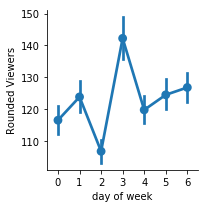

In [4]:
training_data['day of week'] = training_data.Game_Date.dt.dayofweek
g = sns.FacetGrid(training_data)
g.map(sns.pointplot, 'day of week',  'Rounded Viewers')



In [5]:
# just double checking that the graph was correct
training_data[['day of week', 'Rounded Viewers']].groupby(['day of week']).mean()

,Rounded Viewers
day of week,
0,116.475991
1,123.798095
2,106.700065
3,142.218299
4,119.721290
5,124.461662
6,126.770177


In [9]:
#checking the outliers possibly, it was on a tuesday?

training_data.loc[training_data['Rounded Viewers'].idxmax()]

Season                         2017-18
Game_ID                       21700001
Game_Date          2017-10-17 00:00:00
Away_Team                          BOS
Home_Team                          CLE
Country                           C176
Rounded Viewers                  18600
day of week                          1
Name: 145547, dtype: object

In [6]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 2)

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


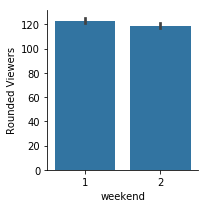

In [4]:
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'weekend',  'Rounded Viewers')

In [7]:
training_data.set_index("Game_ID", inplace = True)

In [8]:
total_views = training_data.groupby('Game_ID')['Rounded Viewers'].sum()

In [9]:
training_data['Total_Views'] = total_views

In [10]:
del total_views

# Getting rid of country/view columns


In [11]:
training_data.drop(['Rounded Viewers', 'Country'], inplace = True, axis = 1)

In [12]:
training_data.drop_duplicates(inplace = True)

In [13]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 0)
player_data['AllStar'] = np.where(player_data.ASG_Team != "None", 1, 0)

In [14]:
player_data.set_index('Game_ID', inplace = True)

In [15]:
allstar = player_data.groupby('Game_ID')['AllStar'].sum()
training_data['AllStar'] = allstar

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


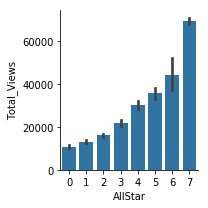

In [16]:
g = sns.FacetGrid(training_data)

g.map(sns.barplot, 'AllStar',  'Total_Views')

# There is a relationship between number of all stars and viewer count as seen here

Now we are going to try model on top of this. First is random forest. Our test model will be just a split of 0.25

In [17]:
from sklearn.model_selection import train_test_split

In [143]:
def randomforest(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    randomforest = RandomForestRegressor(random_state = 0, n_estimators=20, min_samples_leaf= 3)
    randomforest.fit(train_X, train_y)
    randomforest_predictions = randomforest.predict(val_X)
    mape = np.mean(np.abs((val_y - randomforest_predictions) / val_y)) * 100
    print(mape)
    del randomforest_predictions
    del X, y

In [58]:
from xgboost import XGBRegressor

In [144]:
def xgboost(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    xgboost = XGBRegressor()
    xgboost.fit(train_X, train_y)
    xgboostpredict = xgboost.predict(val_X)
    mape = np.mean(np.abs((val_y - xgboostpredict) / val_y)) * 100
    print(mape)
    del xgboostpredict
    del X, y

In [23]:
training_data['2016-17_season'] = training_data['Season'] == '2016-17'

In [25]:
randomforest(training_data)

80.2880153263


c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


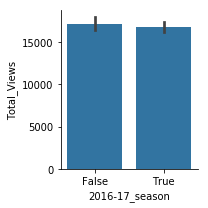

In [254]:
g = sns.FacetGrid(training_data)
g.map(sns.barplot, '2016-17_season',  'Total_Views')

# Adding population of cities to their teams

In [27]:

population_of_city = {'CLE': 2055612, 'NYK': 10153634, 'POR': 2424955,'UTA': 1186187, 'GSW': 4679166, 'SAS': 2429609, 'MIA':  6066387,
                     'ORL': 2441257, 'DAL': 7233323, 'IND': 2004230, 'BOS': 4794447, 'BKN': 10000000, 'TOR': 5928040, 'DET': 4297617,
                     'MIL': 1572482, 'MEM': 1342842, 'NOP': 1268883, 'DEN': 2853077, 'PHI': 6070500, 'OKC': 1373211, 'PHX': 4661537, 
                     'SAC': 2296418, 'HOU': 6772470, 'LAL': 13310447, 'ATL': 5789700, 'WAS': 6131977, 'CHI': 9512999, 'LAC': 13310446,
                     'CHA': 2474314, 'MIN': 3551036 }


game_data['Team_population'] = game_data['Team'].map(population_of_city)
game_data.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Team', 'Location',
       'Wins_Entering_Gm', 'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score',
       'Lead_Changes', 'Ties', 'Largest_Lead', 'Full_Timeouts',
       'Short_Timeouts', 'Qtr_4_Score', 'L2M_Score', 'Team_population'],
      dtype='object')

In [28]:
training_data['Total_population'] = game_data.groupby('Game_ID')['Team_population'].sum()

In [29]:
randomforest(training_data)


61.2855992583


In [39]:
game_data.set_index('Game_ID', inplace = True)

In [43]:
training_data['Home_team_population']= game_data.loc[game_data['Location'] == 'H', ['Team_population']]

In [84]:
randomforest(training_data)

47.0821668554


In [88]:
xgboost(training_data)

47.8233913392


In [91]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [97]:
def cross_val(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
    crossvalpipe = make_pipeline(RandomForestRegressor(random_state = 0, n_estimators=20, min_samples_leaf= 3))
    crossvalpredictor = cross_val_score(crossvalpipe, X, y, scoring = 'neg_mean_absolute_error')
    print(crossvalpredictor)

In [99]:
cross_val(training_data)

[-6330.32067464 -6964.30559658 -7232.02889674]


# results are pretty bad still... Going to try using one hot encoding on the teams

In [109]:
one_hot_predictors = pd.get_dummies(training_data)

In [178]:
def randomforesttwo(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Game_Date", '2016-17_season'], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    randomforest = RandomForestRegressor(random_state = 0, n_estimators=50, min_samples_leaf=1, max_features="auto")
    randomforest.fit(train_X, train_y)
    randomforest_predictions = randomforest.predict(val_X)
    mape = np.mean(np.abs((val_y - randomforest_predictions) / val_y)) * 100
    print(mape)
    del randomforest_predictions
    del X, y

In [179]:
randomforesttwo(one_hot_predictors)

38.4890135734


In [174]:
def xgboosttwo(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Game_Date", '2016-17_season'], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    xgboost = XGBRegressor(n_estimators=1000, learning_rate = 0.05 )
    xgboost.fit(train_X, train_y, early_stopping_rounds = 10, eval_set = [(val_X, val_y)], verbose = False)
    xgboostpredict = xgboost.predict(val_X)
    mape = np.mean(np.abs((val_y - xgboostpredict) / val_y)) * 100
    print(mape)
    del xgboostpredict
    del X, y

In [175]:
xgboosttwo(one_hot_predictors)

38.1029165403


In [168]:
one_hot_predictors.columns

Index(['Game_Date', 'day of week', 'weekend', 'Total_Views', 'AllStar',
       '2016-17_season', 'Total_population', 'Home_team_population',
       'Season_2016-17', 'Season_2017-18', 'Away_Team_ATL', 'Away_Team_BKN',
       'Away_Team_BOS', 'Away_Team_CHA', 'Away_Team_CHI', 'Away_Team_CLE',
       'Away_Team_DAL', 'Away_Team_DEN', 'Away_Team_DET', 'Away_Team_GSW',
       'Away_Team_HOU', 'Away_Team_IND', 'Away_Team_LAC', 'Away_Team_LAL',
       'Away_Team_MEM', 'Away_Team_MIA', 'Away_Team_MIL', 'Away_Team_MIN',
       'Away_Team_NOP', 'Away_Team_NYK', 'Away_Team_OKC', 'Away_Team_ORL',
       'Away_Team_PHI', 'Away_Team_PHX', 'Away_Team_POR', 'Away_Team_SAC',
       'Away_Team_SAS', 'Away_Team_TOR', 'Away_Team_UTA', 'Away_Team_WAS',
       'Home_Team_ATL', 'Home_Team_BKN', 'Home_Team_BOS', 'Home_Team_CHA',
       'Home_Team_CHI', 'Home_Team_CLE', 'Home_Team_DAL', 'Home_Team_DEN',
       'Home_Team_DET', 'Home_Team_GSW', 'Home_Team_HOU', 'Home_Team_IND',
       'Home_Team_LAC', 'Home_Te